Para desarrollar un modelo LSTM que estime el precio de cierre de una acción utilizando datos de Yahoo Finance, vamos a seguir los pasos detallados anteriormente. Aquí tienes el código completo, incluyendo la descarga de datos, preparación de los datos para el modelo LSTM, creación y entrenamiento del modelo, y finalmente la evaluación y visualización de las predicciones.

##**Paso 1: Descargar los datos usando yfinance**


Utilizaremos la librería yfinance para descargar los datos históricos de una acción específica de Yahoo Finance. En este ejemplo, vamos a descargar los datos de Apple (AAPL).

In [9]:
import yfinance as yf

# Descargar datos de Yahoo Finance
ticker = 'AAPL'  # Símbolo de la acción de Apple
data = yf.download(ticker)

# Mostrar los primeros registros para verificar la descarga
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600


##**Paso 2: Preparar los datos para la serie de tiempo (univariado)**

En este caso, trabajaremos solo con la serie de precios de cierre (Close) como datos univariados.

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Seleccionar solo el precio de cierre ajustado
serie_tiempo = data['Close'].values.reshape(-1, 1)

# Escalar los datos en el rango de -1 a 1
scaler = MinMaxScaler(feature_range=(-1, 1))
serie_tiempo_escalada = scaler.fit_transform(serie_tiempo)

# Función para crear secuencias supervisadas
def crear_dataset_supervisado(array, input_length, output_length):
    X, Y = [], []
    for i in range(len(array)-input_length-output_length+1):
        X.append(array[i:i+input_length])
        Y.append(array[i+input_length:i+input_length+output_length])
    return np.array(X), np.array(Y)

# Definir longitud de entrada y salida
INPUT_LENGTH = 30  # 30 días para predecir
OUTPUT_LENGTH = 1  # Predicción un paso adelante

# Crear conjuntos de entrenamiento, validación y prueba
def split_data(data, train_size=0.8, val_size=0.10, test_size=0.10):
    total_size = len(data)
    train_size = int(train_size * total_size)
    val_size = int(val_size * total_size)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

# Dividir los datos en entrenamiento, validación y prueba
train_data, val_data, test_data = split_data(serie_tiempo_escalada)

# Crear datasets supervisados
x_train, y_train = crear_dataset_supervisado(train_data, INPUT_LENGTH, OUTPUT_LENGTH)
x_val, y_val = crear_dataset_supervisado(val_data, INPUT_LENGTH, OUTPUT_LENGTH)
x_test, y_test = crear_dataset_supervisado(test_data, INPUT_LENGTH, OUTPUT_LENGTH)

# Verificar tamaños de los datasets
print(f'Tamaño del set de entrenamiento: X={x_train.shape}, Y={y_train.shape}')
print(f'Tamaño del set de validación: X={x_val.shape}, Y={y_val.shape}')
print(f'Tamaño del set de prueba: X={x_test.shape}, Y={y_test.shape}')


Tamaño del set de entrenamiento: X=(8746, 30, 1), Y=(8746, 1, 1)
Tamaño del set de validación: X=(1067, 30, 1), Y=(1067, 1, 1)
Tamaño del set de prueba: X=(1068, 30, 1), Y=(1068, 1, 1)


##**Paso 3: Crear y entrenar modelos RNN**


Vamos a crear varios modelos LSTM de manera incremental, ajustando hiperparámetros clave como el número de unidades LSTM, la tasa de dropout y el optimizador. Aquí mostramos un ejemplo con un modelo LSTM básico:


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Definir función para crear el modelo LSTM
def crear_modelo_lstm(input_shape, n_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=n_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))
    return model

# Compilar el modelo
def compilar_modelo(modelo, optimizador):
    modelo.compile(optimizer=optimizador, loss='mean_squared_error')
    return modelo

# Entrenar el modelo
def entrenar_modelo(modelo, x, y, epochs, batch_size, validacion):
    historia = modelo.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=validacion, verbose=2)
    return historia

# Parámetros para el entrenamiento
N_UNITS = 50  # Número de unidades LSTM (hiperparámetro a ajustar)
DROPOUT_RATE = 0.2  # Tasa de dropout para regularización (hiperparámetro a ajustar)
EPOCHS = 50  # Número de épocas de entrenamiento
BATCH_SIZE = 32  # Tamaño del lote de datos

# Crear y compilar el modelo LSTM
modelo = crear_modelo_lstm(input_shape=(x_train.shape[1], x_train.shape[2]), n_units=N_UNITS, dropout_rate=DROPOUT_RATE)
modelo_compilado = compilar_modelo(modelo, optimizador=RMSprop())

# Entrenar el modelo
historia = entrenar_modelo(modelo_compilado, x_train, y_train,
                           epochs=EPOCHS, batch_size=BATCH_SIZE, validacion=(x_val, y_val))



Epoch 1/50
240/240 - 9s - loss: 0.0180 - val_loss: 0.0063 - 9s/epoch - 37ms/step
Epoch 2/50
240/240 - 5s - loss: 0.0068 - val_loss: 0.0023 - 5s/epoch - 20ms/step
Epoch 3/50
240/240 - 4s - loss: 0.0056 - val_loss: 0.0057 - 4s/epoch - 16ms/step
Epoch 4/50
240/240 - 5s - loss: 0.0045 - val_loss: 0.0268 - 5s/epoch - 22ms/step
Epoch 5/50
240/240 - 4s - loss: 0.0041 - val_loss: 0.0059 - 4s/epoch - 15ms/step
Epoch 6/50
240/240 - 4s - loss: 0.0036 - val_loss: 0.0170 - 4s/epoch - 17ms/step
Epoch 7/50
240/240 - 6s - loss: 0.0031 - val_loss: 0.0069 - 6s/epoch - 25ms/step
Epoch 8/50
240/240 - 4s - loss: 0.0027 - val_loss: 0.0074 - 4s/epoch - 15ms/step
Epoch 9/50
240/240 - 4s - loss: 0.0024 - val_loss: 0.0238 - 4s/epoch - 15ms/step
Epoch 10/50
240/240 - 5s - loss: 0.0021 - val_loss: 0.0189 - 5s/epoch - 20ms/step
Epoch 11/50
240/240 - 9s - loss: 0.0018 - val_loss: 0.0223 - 9s/epoch - 38ms/step
Epoch 12/50
240/240 - 11s - loss: 0.0016 - val_loss: 0.0077 - 11s/epoch - 44ms/step
Epoch 13/50
240/240 - 6

##**Paso 4: Evaluar el modelo y visualizar predicciones**


Finalmente, vamos a evaluar el desempeño del modelo entrenado y visualizar las predicciones generadas.

Pérdida en el set de prueba: 0.018733380362391472
34/34 [==============================] - 0s 8ms/step


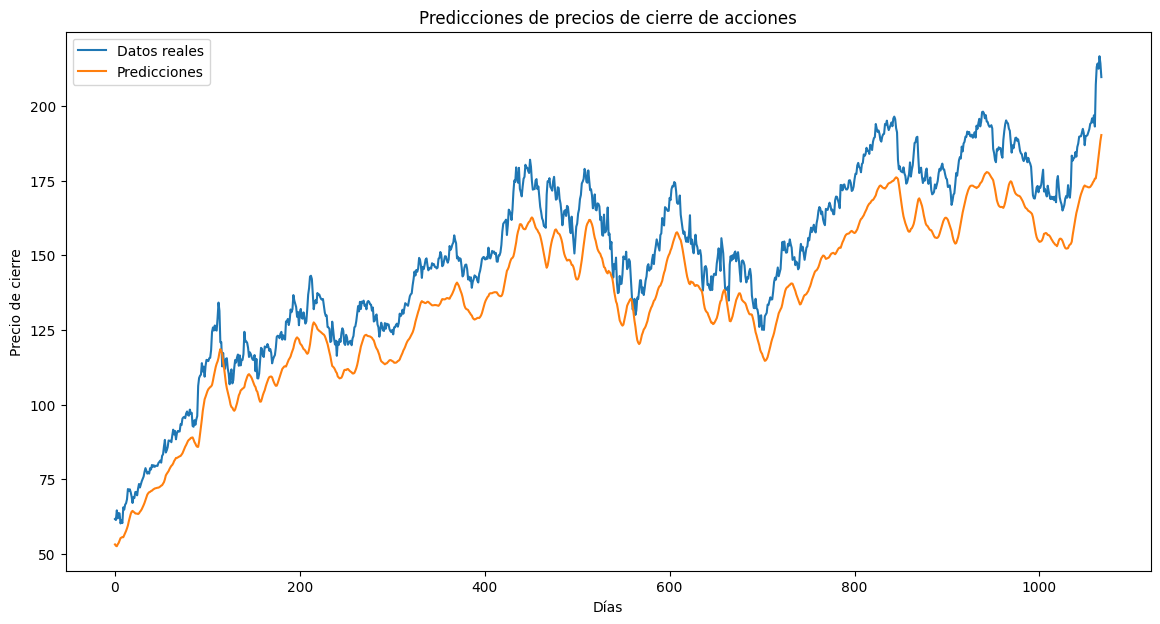

In [14]:
import matplotlib.pyplot as plt

# Evaluar el modelo en el set de prueba
loss = modelo.evaluate(x_test, y_test, verbose=0)
print(f'Pérdida en el set de prueba: {loss}')

# Predecir en el set de prueba
predicciones = modelo.predict(x_test)

# Invertir la escala de las predicciones para comparar con los datos originales
predicciones_originales = scaler.inverse_transform(predicciones)
y_test_originales = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizar las predicciones
plt.figure(figsize=(14, 7))
plt.plot(y_test_originales, label='Datos reales')
plt.plot(predicciones_originales, label='Predicciones')
plt.title('Predicciones de precios de cierre de acciones')
plt.xlabel('Días')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()


Este flujo completo te permitirá desarrollar, entrenar y evaluar un modelo LSTM para predecir el precio de una acción utilizando datos históricos descargados de Yahoo Finance. Asegúrate de ajustar los hiperparámetros y probar diferentes arquitecturas de modelos para obtener el mejor rendimiento posible.